# Sameer Gupta

MNIST Dataset

## Section 0: Loading the data

There is no code for you to fill out in this section but please make sure you understand what the code* is doing so you aren't confused in later parts. Basically, this section loads the training, testing, and validation data of the dog images for you.

In [1]:
import keras
import numpy as np
import scipy.misc
import cv2
import json
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras.datasets import mnist
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Lambda, Dense, Activation
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.preprocessing import image    
from matplotlib import pyplot
from scipy.misc import toimage
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.util import random_noise
from skimage import exposure


/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Loads the datasets and gets list of dog names (labels). `X_train`, `X_val`, and `X_test` contain lists of image paths to the data.

In [2]:
num_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Normalize Data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


Visualizing 9 of the images in the data.

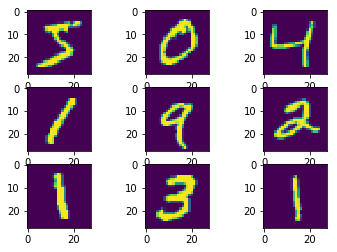

In [3]:
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i])
# show the plot
pyplot.show()

## Section 1: Data augmentation

In this section we want you to perform some sort of data augmentation as we learnt about in class. This is because we only have roughly 200 examples per label which in deep learning isn't generally enough. Therefore, to improve performance we can use data augmentation as a trick to generate more training examples.

Make sure you try at least **TWO** methods of augmentation. Please explain each augmentation and what it does as well as visualizing at least one example of each augmentation. If you do choose to try more, make sure to incremement `NB_AUGMENTATIONS` by one each time.

If you want to change the size of your image (smaller images train faster), you want to change `IMG_SIZE`.

An example augmentation of flipping the image has already been done for you in `example_augment`.

In [4]:
def example_augment(img):
    augmented_img = np.fliplr(img)
    return augmented_img

**Augmentation Explanation:** In this augmentation I use the skimage library to add random noise to the image.

In [5]:
def augmentation_1(img):   
    augmented_img = random_noise(img)
    return augmented_img

**Augmentation Explanation:** Use the skimage library to add gamma correction to the image. 

In [6]:
def augmentation_2(img):
    augmented_img = exposure.adjust_gamma(img, gamma=0.4, gain=0.9)
    return augmented_img

Visualizing your augmentations.

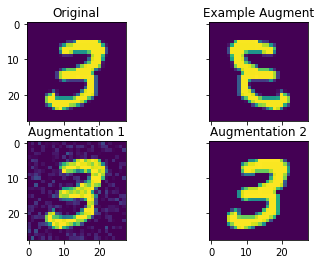

In [7]:
sample_img = X_train[7]
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(sample_img)
axarr[0, 0].set_title('Original')
axarr[0, 1].imshow(example_augment(sample_img))
axarr[0, 1].set_title('Example Augment')
axarr[1, 0].imshow(augmentation_1(sample_img))
axarr[1, 0].set_title('Augmentation 1')
axarr[1, 1].imshow(augmentation_2(sample_img))
axarr[1, 1].set_title('Augmentation 2')

for ax in axarr.flat:
    ax.label_outer()

In [8]:
NB_AUGMENTATIONS = 0
# Don't change this for MNIST.
IMG_SIZE = 28

def batch_generator(images, labels, augment=True, batch_size=32):
    batch_images = []
    batch_labels = []
    sample_count = 0
    
    while True:
        # Shuffle indices to minimize overfitting.
        for i in np.random.permutation(images.shape[0]):

            img = images[i]
            img = np.expand_dims(img, axis=3)
            label = labels[i]

            batch_images.append(img)
            batch_labels.append(label)
            sample_count += 1

            if augment:
                # Perform Augmentation (Flipping the Image)
                img_example_augment = example_augment(img)
                batch_images.append(img_example_augment)
                batch_labels.append(label)
                
                # Perform Augmentation 1
                img_augment_1 = augmentation_1(img)
                batch_images.append(img_augment_1)
                batch_labels.append(label)

                # Perform Augmentation 2
                img_augment_2 = augmentation_2(img)
                batch_images.append(img_augment_2)
                batch_labels.append(label)

            if ((sample_count % batch_size == 0) or (sample_count % len(images) == 0)):
                yield np.array(batch_images), np.array(batch_labels)
                # Reset batch.
                batch_images = []
                batch_labels = []

## Section 2: Building the model

In this section you will write all the code to build your Convolutional Neural Network model in Keras. The model should output `NUM_CLASSES` (10 in this case) values which sum up to 1 and are each the probability that the number represented in the photo. 

**Explanation:** The Model consists of a 2D convolutional layer which takes an input of (28,28,1). It is followed by Max pooling which pools the sum of the previous convoluted result. It is followed by drouput and then a similar set of layers but with more filters. This shrinks the image down to a smaller vector and gives us higher accuracy. 

Finally the result is put through a flatten which converts the image to a vector which is passed through a dense layer and then finally a 10 ouput softmax activation dense layer for classification.

In [9]:
model = Sequential()

model.add(Conv2D(32,(3,3), input_shape=(28,28,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(10,activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
__________

In [10]:
# # FOR YOU TO CHOOSE
optimizer = 'adam'
loss = 'categorical_crossentropy'

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Section 3: Training the model

The code to train your model has been done for you already as it is a bit different than before due to the batch generator. Notice how we set `augment` to false for the validation generator. It is important never to augment your validation nor testing data since that can bias (inflate or deflate) the accuracy scores. The code also saves your models weights in the end which we can use for testing later on so we don't have to retrain it entirely.

In [14]:
generator_train = batch_generator(X_train, y_train, augment=False)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

model.fit(X_train, y_train, epochs =20, verbose = 1,batch_size = 64)
#model.fit_generator(
  #      generator_train,
   #     steps_per_epoch= (NB_AUGMENTATIONS+1) * len(X_train),
    #    epochs=1,
     #   verbose=1)

# Save the weights for grading.
model.save_weights('modelMIST.h5', True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

Epoch 1/20
60000/60000 [==============================] - 23s 387us/step - loss: 0.0111 - acc: 0.9961
Epoch 2/20
60000/60000 [==============================] - 23s 382us/step - loss: 0.0114 - acc: 0.9957
Epoch 3/20
60000/60000 [==============================] - 23s 386us/step - loss: 0.0111 - acc: 0.9959
Epoch 4/20
60000/60000 [==============================] - 23s 376us/step - loss: 0.0107 - acc: 0.9965
Epoch 5/20
60000/60000 [==============================] - 22s 372us/step - loss: 0.0092 - acc: 0.9971
Epoch 6/20
60000/60000 [==============================] - 23s 381us/step - loss: 0.0095 - acc: 0.9967
Epoch 7/20
60000/60000 [==============================] - 23s 384us/step - loss: 0.0085 - acc: 0.9972
Epoch 8/20
60000/60000 [==============================] - 23s 377us/step - loss: 0.0099 - acc: 0.9966
Epoch 9/20
60000/60000 [==============================] - 23s 376us/step - loss: 0.0100 - acc: 0.9967
Epoch 10/20
60000/60000 [==============================] - 23s 387us/step - loss: 

In [16]:
print(history.history.keys())

dict_keys(['loss', 'acc'])


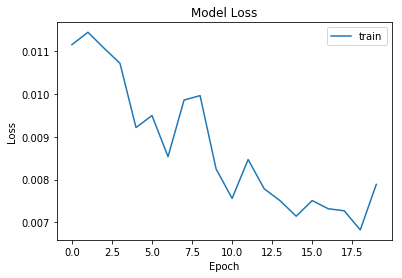

In [21]:
# Summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['acc'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper right')
plt.show()

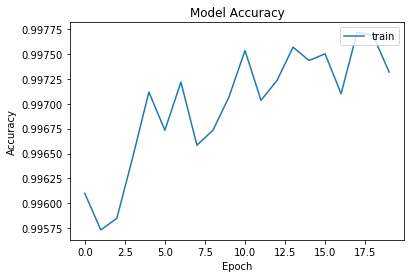

In [22]:
# Summarize history for accuracy
#plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper right')
plt.show()

## Section 4: Evaluation

In this section you will compute the accuracy of your model on the test data from Section 0. Make sure you very clearly have a cell that outputs and prints the percentage accuracy of your model. You will also include any code used to analyze the results here.

A confusion matrix would be nice but since there are so many classes it will be hard to cleanly visualize. Instead f1, precision, and recall scores for each class would be cleaner to read.

**Explanation:** First I included a percision report which includes the percision and f1 score of each digit. The accuracy of the model is 98.5% which is pretty impressive. After this I plot a confusion matrix which shows the accuracy of matching for the 10 classes. It shows the highest accuracy in predicting 1 and lowest for 5. Also it shows the amount of times it mismatches the test data to the wrong class. It is pretty low, the highest being for 7 being misunderstood for 2.

In [24]:
score = model.evaluate(X_test,y_test,verbose=False)

y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

print("Accurary: %.4f%%" %(score[1]*100))

Accurary: 98.5400%


In [31]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test_class,y_pred_class))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       980
          1       0.96      1.00      0.98      1135
          2       1.00      0.96      0.98      1032
          3       0.97      1.00      0.98      1010
          4       0.99      0.99      0.99       982
          5       0.99      0.98      0.99       892
          6       1.00      0.99      0.99       958
          7       0.98      0.98      0.98      1028
          8       0.99      0.99      0.99       974
          9       0.99      0.98      0.98      1009

avg / total       0.99      0.99      0.99     10000



In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


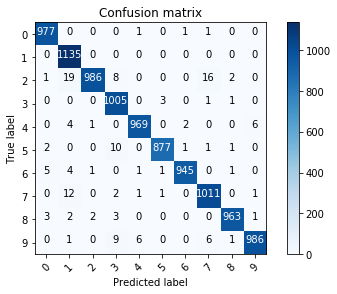

In [33]:
cnf_matrix = confusion_matrix(y_test_class,y_pred_class)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3','4','5','6','7','8','9'], title='Confusion matrix')

\* Project Code inspired and taken from Udacity's AI Nanodegress https://github.com/mahavird/dog-project. All credit for the helper methods to load the dataset goes to Udacity.